In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

We make lists of required entries which we will use (years, semesters, programs).

In [2]:
programs = ["Informatique"]
years = ["2007-2008", "2008-2009", "2009-2010", "2010-2011", "2011-2012", "2012-2013",
         "2013-2014", "2014-2015", "2015-2016", "2016-2017"]
bachelor_semesters = ["Bachelor semestre 1", "Bachelor semestre 2", "Bachelor semestre 3", "Bachelor semestre 4",
                     "Bachelor semestre 5", "Bachelor semestre 6"]
master_semesters = ["Master semestre 1", "Master semestre 2", "Master semestre 3", "Projet Master automne", 
                   "Projet Master printemps"]

In the next few cells we are creating URL of data.
In order to approach data we need two URLs (to create this URLs we use the same "base link" with two different endings - .filter and .html). 
First URL is URL of empty form. We approach this URL (using request library) and get html code of page. By using BeautifulSoup library we parse it and get values of parameters we need (Informatique program, range of years and semesters). Using the same link with these parameters set, we approach page from which we extract value of "so called" "GPS" parameter. Now, we use second link with this GPS parameter set, in order to approach page with data in it. Some of parameters (year, semester, program) that can be set are not necessary in order to obtain this page.

In [3]:
report_model_param = "133685247"
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS"
r = requests.get(base_url+".filter", params = {"ww_i_reportModel": report_model_param})
form = BeautifulSoup(r.text, 'html.parser')
b_list_param = form.find_all("input", attrs={"name":"ww_b_list"})[0]['value']
report_model_xsl_param = form.find_all("input", attrs={"name":"ww_i_reportModelXsl"})[0]['value']

In [4]:
program_values = {}
for program in programs:
    program_values[program] = form.find_all("option", string=program)[0]['value']

In [5]:
year_values = {}
for year in years:
    year_values[year] = form.find_all("option", string=year)[0]['value']

In [6]:
bachelor_semester_values = {}
for semester in bachelor_semesters:
    bachelor_semester_values[semester] = form.find_all("option", string=semester)[0]['value']

In [7]:
master_semester_values = {}
for semester in master_semesters:
    master_semester_values[semester] = form.find_all("option", string=semester)[0]['value']

Some of steps we explained in previos comment are gathered in a function which we created to obtain data which corresponds to exact school year, program and semester. Function returns requred data in DataFrame.

In [8]:
def get_dataset(prog_val, y_val, sem_val):
    params = {"ww_i_reportModel": report_model_param, 
              "ww_b_list": b_list_param, 
              "ww_i_reportModelXsl": report_model_xsl_param, 
              "ww_x_UNITE_ACAD": prog_val,
              "ww_x_PERIODE_ACAD": y_val,
              "ww_x_PERIODE_PEDAGO": sem_val}
    r = requests.get(base_url+".filter", params = params)
    set_page = BeautifulSoup(r.text, 'html.parser')
    gps_string = set_page.find_all("a", attrs={"class": "ww_x_GPS"})[1]["onclick"]
    gps_value = ''.join(list(filter(str.isdigit, gps_string)))
    params = {"ww_i_reportModel": report_model_param, 
              "ww_i_reportModelXsl": report_model_xsl_param,
              "ww_x_GPS": gps_value}
    r = requests.get(base_url+".html", params = params)
    res=pd.read_html(r.text, skiprows = [0], header = 0, index_col = "Nom Prénom")
    if len(res):
        return res[0].drop("Unnamed: 11", axis=1)
    else:
        return pd.DataFrame(columns = ['Civilité', 'Orientation Bachelor', 'Orientation Master', 
                                       'Spécialisation', 'Filière opt.', 'Mineur', 'Statut', 'Type Echange', 
                                       'Ecole Echange', 'No Sciper'])

As we do not want to download data each time we run code (possible problems with network), we serialize results after first downloading and on other executions we check if there is something already saved and use previously downloaded data. Afterwards we print shapes of data for al combinations of year, semester.

In [9]:
import os.path
if os.path.isfile("bachelor_data.pickle"):
    with open('bachelor_data.pickle', 'rb') as handle:
        bachelor_datasets = pickle.load(handle)
else:
    bachelor_datasets = {}
    for year in years:
        bachelor_datasets[year] = {}
    for year in years:
        for semester in bachelor_semesters:
            print(year, semester)
            bachelor_datasets[year][semester] = get_dataset(program_values[programs[0]], 
                                                            year_values[year], bachelor_semester_values[semester])


In [10]:
if not os.path.isfile("bachelor_data.pickle"):
    with open('bachelor_data.pickle', 'wb') as handle:
        pickle.dump(bachelor_datasets, handle)

In [11]:
for year in years:
    for semester in bachelor_semesters:
        print(year, semester, bachelor_datasets[year][semester].shape)

2007-2008 Bachelor semestre 1 (90, 10)
2007-2008 Bachelor semestre 2 (72, 10)
2007-2008 Bachelor semestre 3 (50, 10)
2007-2008 Bachelor semestre 4 (48, 10)
2007-2008 Bachelor semestre 5 (48, 10)
2007-2008 Bachelor semestre 6 (38, 10)
2008-2009 Bachelor semestre 1 (96, 10)
2008-2009 Bachelor semestre 2 (74, 10)
2008-2009 Bachelor semestre 3 (53, 10)
2008-2009 Bachelor semestre 4 (51, 10)
2008-2009 Bachelor semestre 5 (57, 10)
2008-2009 Bachelor semestre 6 (51, 10)
2009-2010 Bachelor semestre 1 (117, 10)
2009-2010 Bachelor semestre 2 (101, 10)
2009-2010 Bachelor semestre 3 (54, 10)
2009-2010 Bachelor semestre 4 (52, 10)
2009-2010 Bachelor semestre 5 (75, 10)
2009-2010 Bachelor semestre 6 (60, 10)
2010-2011 Bachelor semestre 1 (153, 10)
2010-2011 Bachelor semestre 2 (125, 10)
2010-2011 Bachelor semestre 3 (51, 10)
2010-2011 Bachelor semestre 4 (51, 10)
2010-2011 Bachelor semestre 5 (62, 10)
2010-2011 Bachelor semestre 6 (52, 10)
2011-2012 Bachelor semestre 1 (166, 10)
2011-2012 Bachelor s

We divided semesters to "Bachelors semesters" and "Master semesters", therefore we need to repeat steps we described before for "Bachelor semesters" to "Master semesters".

In [12]:
if os.path.isfile("master_data.pickle"):
    with open('master_data.pickle', 'rb') as handle:
        master_datasets = pickle.load(handle)
else:
    master_datasets = {}
    for year in years:
        master_datasets[year] = {}
    for year in years:
        for semester in master_semesters:
            print(year, semester)
            master_datasets[year][semester] = get_dataset(program_values[programs[0]], 
                                                            year_values[year], master_semester_values[semester])

In [13]:
if not os.path.isfile("bachelor_data.pickle"):
    with open('master_data.pickle', 'wb') as handle:
        pickle.dump(master_datasets, handle)

In [14]:
for year in years:
    for semester in master_semesters:
        print(year, semester, master_datasets[year][semester].shape)

2007-2008 Master semestre 1 (71, 10)
2007-2008 Master semestre 2 (87, 10)
2007-2008 Master semestre 3 (65, 10)
2007-2008 Projet Master automne (1, 10)
2007-2008 Projet Master printemps (6, 10)
2008-2009 Master semestre 1 (60, 10)
2008-2009 Master semestre 2 (64, 10)
2008-2009 Master semestre 3 (48, 10)
2008-2009 Projet Master automne (4, 10)
2008-2009 Projet Master printemps (6, 10)
2009-2010 Master semestre 1 (52, 10)
2009-2010 Master semestre 2 (62, 10)
2009-2010 Master semestre 3 (34, 10)
2009-2010 Projet Master automne (3, 10)
2009-2010 Projet Master printemps (8, 10)
2010-2011 Master semestre 1 (96, 10)
2010-2011 Master semestre 2 (109, 10)
2010-2011 Master semestre 3 (40, 10)
2010-2011 Projet Master automne (3, 10)
2010-2011 Projet Master printemps (7, 10)
2011-2012 Master semestre 1 (102, 10)
2011-2012 Master semestre 2 (123, 10)
2011-2012 Master semestre 3 (67, 10)
2011-2012 Projet Master automne (9, 10)
2011-2012 Projet Master printemps (13, 10)
2012-2013 Master semestre 1 (88

We stored bachelor's and master's data in 2 matrices where each cell is a DataFrame containing data for indexed year and semester (first index corresponds to the academic year (e.g. '2015-2016') and second index corresponds to the semester of the program (e.g. 'Bachelor semestre 1')

1.In the next few cells we will focus on the Bachelor's data in order to answer Question 1. Firstly, we will use matrix containing bachelor's data to create DataFrame-s which corresponds to 'Bachelor semestre 1', 'Bachelor semestre 5' and 'Bachelor semestre 6'. These 3 new DataFrame-s are bachelor_sem1, bachelor_sem5 and bachelor_sem6. So bachelor_sem1 would be a DataFrame consisting entries in 'Bachelor semestre 1' across all academic years. Similarly, bachelor_sem5 and bachelor_sem6 are consisted of entries in 'Bachelor semestre 5' and 'Bachelor semestre 6'.

We now create another DataFrame which containes students who are in bachelor_sem1, bachelor sem6 and bachelor_sem5 (We added a check for bachelor semester 5 also, because student could finish semester 6 and skip semester 5 before, and we can't say for this studenst that he/she graduated). This explains our choice of the definition of graduated students (those are students who we take into account for the statisical tests). We perform a check over all entries of students in the bachelor_sem1 DataFrame and check if they have corresponding entries in bachelor_sem5 and bachelor_sem6 DataFrames. Student entries that satisfy this criteria are then added to a new DataFrame that is named graduated_students.  Therefore only those students who have entries in the first, fifth and sixth semester are considered for the further statistical inferences.

In [15]:
sem_1 = 'Bachelor semestre 1'
sem_5 = 'Bachelor semestre 5'
sem_6 = 'Bachelor semestre 6'
bachelor_sem1 = pd.DataFrame()
bachelor_sem5 = pd.DataFrame()
bachelor_sem6 = pd.DataFrame()
for y in years:
    
    with_years = bachelor_datasets[y][sem_1].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    bachelor_sem1=bachelor_sem1.append(with_years)
    
    with_years = bachelor_datasets[y][sem_5].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    bachelor_sem5=bachelor_sem5.append(with_years)
                             
    with_years = bachelor_datasets[y][sem_6].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    bachelor_sem6=bachelor_sem6.append(with_years) 
                             
graduated_students = pd.DataFrame()
for index, row in bachelor_sem1.iterrows():
    if bachelor_sem5['No Sciper'].isin([row['No Sciper']]).values.any() & \
        bachelor_sem6['No Sciper'].isin([row['No Sciper']]).values.any():
        graduated_students=graduated_students.append(row)
del (graduated_students['Beginning Year'])
graduated_students.head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
Arévalo Christian,Monsieur,NaN,NaN,NaN,169569.0,NaN,NaN,NaN,Présent,NaN
Aubelle Flavien,Monsieur,NaN,NaN,NaN,174905.0,NaN,NaN,NaN,Présent,NaN
Baeriswyl Jonathan,Monsieur,NaN,NaN,NaN,179406.0,NaN,NaN,NaN,Présent,NaN
Barroco Michael,Monsieur,NaN,NaN,NaN,179428.0,NaN,NaN,NaN,Présent,NaN
Bindschaedler Vincent,Monsieur,NaN,NaN,NaN,179449.0,NaN,NaN,NaN,Présent,NaN


After we have this DataFrame of graduated students, we need to figure out the time they took to complete their bachelors program in months. For each student who is added to graduated_students DataFrame we find its first apperience in bachelor_sem1 DataFrame and we take year which is associated with this apperiance. We consider this year as the beginning year of his studies. Similarly, we find student's last apperiance in bachelor_sem5 and bachelor_sem6 and we take years which are associatied with these apperiences (we name this years y5 and y6 respectively). Obviously, student could finish his studies with bachelor semester 5 or bachelor semester 6. If y5>y6, student finished his studies in semester 5. Anyway, as the finish year of his studies, we take year y6 (when he finished 6 semester), but in case of y5>y6 we add 6 months to full amount of study duration. Total duration of studies for each student in months is calculated as 12*(finish year - beginning year) with corrections which we mentioned above. 

In [16]:
graduated_students.drop_duplicates('No Sciper', inplace=True)
months = [0]*len(graduated_students['No Sciper'])
for ind, sciper in enumerate(graduated_students['No Sciper']):
    years_6sem = np.where(bachelor_sem6['No Sciper'] == sciper)
    years_5sem = np.where(bachelor_sem5['No Sciper'] == sciper)
    finish_year_6 = bachelor_sem6['Beginning Year'].ix[years_6sem[0][len(years_6sem[0])-1]]
    finish_year_5 = bachelor_sem5['Beginning Year'].ix[years_5sem[0][len(years_5sem[0])-1]]
    years_1sem = np.where(bachelor_sem1['No Sciper'] == sciper)
    beginning_year = bachelor_sem1['Beginning Year'].ix[years_1sem[0][0]]
    
    months[ind] =12*(int(finish_year_6[0:4]) - int (beginning_year[0:4])+1)
    if (finish_year_5>finish_year_6): months[ind] +=6
        
graduated_students['Months'] = pd.Series(months, index=graduated_students.index)
graduated_students.head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,Months
Arévalo Christian,Monsieur,NaN,NaN,NaN,169569.0,NaN,NaN,NaN,Présent,NaN,36
Aubelle Flavien,Monsieur,NaN,NaN,NaN,174905.0,NaN,NaN,NaN,Présent,NaN,60
Baeriswyl Jonathan,Monsieur,NaN,NaN,NaN,179406.0,NaN,NaN,NaN,Présent,NaN,48
Barroco Michael,Monsieur,NaN,NaN,NaN,179428.0,NaN,NaN,NaN,Présent,NaN,48
Bindschaedler Vincent,Monsieur,NaN,NaN,NaN,179449.0,NaN,NaN,NaN,Présent,NaN,36


We spot that average number of months is bigger for male than for female. On the other hand, when we apply robust statistic we see that number of months considering 50% of population is equal for male and female. We can conclude that average value for male is only bigger because there exist "bigger" outliers (max=84 months). 
        
To compare means of two sets (for each sex) we use t_two sample test. It is most convenient because we need test to estimate the differences between two means. 
We call function stats.ttest_ind where a and b are arrays of values for men and women, those array we obtain from graduated_grouped['Months']. After execution we obtain result in a form of Ttest_indResult(statistic=1.3437005678090845, pvalue=0.18785555340784144). Since the second number (pvalue) is number bigger than 0.05 (we used 95% confidence level and corresponding significance level is 5 %), that means that in more than 5% of cases same distributions would differ this much. Hence, we conclude that difference in average is not statistically significant.

Civilité
Madame      40.758621
Monsieur    42.880435
Name: Months, dtype: float64
Civilité       
Madame    count     29.000000
          mean      40.758621
          std        8.078433
          min       36.000000
          25%       36.000000
          50%       36.000000
          75%       48.000000
          max       66.000000
Monsieur  count    368.000000
          mean      42.880435
          std        9.458750
          min       36.000000
          25%       36.000000
          50%       36.000000
          75%       48.000000
          max       84.000000
Name: Months, dtype: float64


Ttest_indResult(statistic=1.3437005678090845, pvalue=0.18785555340784144)

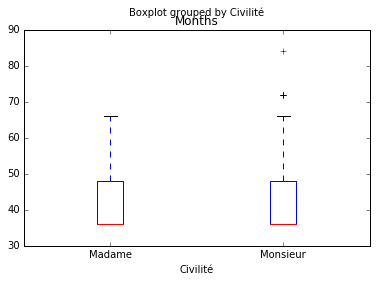

In [17]:
graduated_grouped = graduated_students.groupby(graduated_students.Civilité)
print(graduated_grouped['Months'].mean())
print(graduated_grouped['Months'].describe()) 
graduated_students.boxplot(column='Months', by='Civilité', grid=False)

splitted = [graduated_grouped.get_group(x) for x in graduated_grouped.groups]
stats.ttest_ind(a=splitted[0]['Months'], b=splitted[1]['Months'], equal_var=False)

2.In the next few cells we will focus on the Master's data in order to answer Question 2. Firstly, we will use matrix containing master's data to create DataFrame-s which corresponds to 'Master semestre 1', 'Master semestre 2', 'Master semestre 3', 'Projet Master automne' and 'Projet Master printemps'. These 5 new DataFrame-s are master_sem1, master_sem2, master_sem3, master_proj_a and master_proj_p. So master_sem1 would be a DataFrame consisting entries in 'Master semestre 1' across all academic years. Similarly, master_sem1, master_sem2, master_sem3, master_proj_a and master_proj_p are consisted of entries in 'Master semestre 2', 'Master semestre 3', 'Projet Master automne' and 'Projet Master printemps'.

We now create another DataFrame in the following manner: If a student is in the master_sem1 and master_sem2 and not in the master_sem3 we add him to our DataFrame (these are students who only studied for two semesters and who didn't take specialization), unless his first semester is in year '2016-2017'. Also, if a student is in the master_sem1 and master_sem2 and in the master_sem3 we add him to our DataFrame (these are students who studied for more than two semesters and who might took specialization), unless his third semester is in year '2016-2017'. This explains our choice of the definition of graduated master students (those are students who we take into account for the statisical tests). We perform a check over all entries of students in the master_sem1 DataFrame and check if they have corresponding entries in master_sem2 and master_sem3 DataFrames. Student entries that satisfy criteria which is described above are then added to a new DataFrame that is named graduated_master. 

In [18]:
sem_1 = 'Master semestre 1'
sem_2 = 'Master semestre 2'
sem_3 = 'Master semestre 3'
proj_a = 'Projet Master automne'
proj_p = 'Projet Master printemps'
master_sem1 = pd.DataFrame()
master_sem2 = pd.DataFrame()
master_sem3 = pd.DataFrame()
master_proj_a = pd.DataFrame()
master_proj_p = pd.DataFrame()
for y in years:
    with_years = master_datasets[y][sem_1].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    master_sem1=master_sem1.append(with_years)
    
    with_years = master_datasets[y][sem_2].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    master_sem2=master_sem2.append(with_years)
                             
    with_years = master_datasets[y][sem_3].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    master_sem3=master_sem3.append(with_years) 
    
    with_years = master_datasets[y][proj_a].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    master_proj_a=master_proj_a.append(with_years) 
    
    with_years = master_datasets[y][proj_p].copy()
    with_years['Beginning Year'] = pd.Series([y]*with_years.shape[0], index=with_years.index)
    master_proj_p=master_proj_p.append(with_years) 
                             
graduated_master = pd.DataFrame()
for index, row in master_sem1.iterrows():
    years_1sem = np.where(master_sem1['No Sciper'] == row['No Sciper'])
    years_2sem = np.where(master_sem2['No Sciper'] == row['No Sciper'])
    if master_sem2['No Sciper'].isin([row['No Sciper']]).values.any() and not master_sem3['No Sciper'].isin([row['No Sciper']]).values.any():    
        if master_sem1.ix[years_1sem[0][len(years_1sem[0])-1]]['Beginning Year']!= '2016-2017':
            graduated_master=graduated_master.append(master_sem2.ix[years_2sem[0][len(years_2sem[0])-1]])
            graduated_master.ix[graduated_master.shape[0]-1, 'Beginning Year']= int(master_sem1.ix[years_1sem[0][0]]['Beginning Year'][0:4])
    elif master_sem2['No Sciper'].isin([row['No Sciper']]).values.any() and master_sem3['No Sciper'].isin([row['No Sciper']]).values.any():
        years_3sem = np.where(master_sem3['No Sciper'] == row['No Sciper'])
        if master_sem3.ix[years_3sem[0][len(years_3sem[0])-1]]['Beginning Year']!= '2016-2017':
            if not (str(master_sem2.ix[years_2sem[0][len(years_2sem[0])-1]]['Spécialisation'])=='nan'):
                graduated_master=graduated_master.append(master_sem2.ix[years_2sem[0][len(years_2sem[0])-1]])
                graduated_master.ix[graduated_master.shape[0]-1, 'Beginning Year']= int (master_sem1.ix[years_1sem[0][0]]['Beginning Year'][0:4])
            else:
                graduated_master=graduated_master.append(master_sem3.ix[years_3sem[0][len(years_3sem[0])-1]])
                graduated_master.ix[graduated_master.shape[0]-1, 'Beginning Year']= int(master_sem1.ix[years_1sem[0][0]]['Beginning Year'][0:4])
graduated_master.head()

,Beginning Year,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
Aeberhard François-Xavier,2007,Monsieur,NaN,NaN,NaN,153066.0,NaN,NaN,Internet computing,Présent,NaN
Agarwal Megha,2007,Madame,NaN,NaN,NaN,180027.0,NaN,NaN,NaN,Présent,NaN
Anagnostaras David,2007,Monsieur,NaN,NaN,"Mineur en Management, technologie et entrepren...",152232.0,NaN,NaN,NaN,Présent,NaN
Auroux Damien,2007,Monsieur,NaN,NaN,NaN,177395.0,NaN,NaN,Internet computing,Présent,NaN
Awalebo Joseph,2007,Monsieur,NaN,NaN,NaN,161970.0,NaN,NaN,NaN,Stage,NaN


In [19]:
graduated_master.drop_duplicates('No Sciper', inplace=True)
months = [0]*len(graduated_master['No Sciper'])
for ind, sciper in enumerate(graduated_master['No Sciper']):
    
    years_proj_a = np.where(master_proj_a['No Sciper'] == sciper)
    years_proj_p = np.where(master_proj_p['No Sciper'] == sciper)
    years_3sem = np.where(master_sem3['No Sciper'] == sciper)
    years_2sem = np.where(master_sem2['No Sciper'] == sciper)
    years_1sem = np.where(master_sem1['No Sciper'] == sciper)
    
    begin_sem1 = master_sem1['Beginning Year'].ix[years_1sem[0][0]]
    begin_sem2 = master_sem2['Beginning Year'].ix[years_2sem[0][0]]
    beginning_master = min(int(begin_sem1[0:4]), int(begin_sem2[0:4]))
    if int(begin_sem2[0:4])<int(begin_sem1[0:4]): months[ind]-=6 
    
    finish_year_proj_a =0
    finish_year_proj_p =0
    if len(years_proj_a[0])!= 0 or len(years_proj_p[0])!= 0:
        if len(years_proj_a[0])!= 0: 
            finish_year_proj_a = master_proj_a['Beginning Year'].ix[years_proj_a[0][len(years_proj_a[0])-1]] 
            finish_year_proj_a =int(finish_year_proj_a[0:4])
        if len(years_proj_p[0])!= 0: 
            finish_year_proj_p = master_proj_p['Beginning Year'].ix[years_proj_p[0][len(years_proj_p[0])-1]]
            finish_year_proj_p =int(finish_year_proj_p[0:4])
        if finish_year_proj_a>finish_year_proj_p: months[ind] -=6
        finish_master = max(finish_year_proj_a, finish_year_proj_p) 
    else:
        finish_year_sem1 = master_sem1['Beginning Year'].ix[years_1sem[0][len(years_1sem[0])-1]] 
        finish_year_sem2 = master_sem2['Beginning Year'].ix[years_2sem[0][len(years_2sem[0])-1]] 
        if  master_sem3['No Sciper'].isin([sciper]).values.any():
            finish_year_sem3 = master_sem3['Beginning Year'].ix[years_3sem[0][len(years_3sem[0])-1]]
            finish_master = max(int(finish_year_sem1[0:4]), int(finish_year_sem2[0:4]), int(finish_year_sem3[0:4]))
            if int(finish_year_sem1[0:4])>int(finish_year_sem2[0:4]) or int(finish_year_sem3[0:4])>int(finish_year_sem2[0:4]):
                months[ind]-=6
        else: 
            finish_master = max(int(finish_year_sem1[0:4]), int(finish_year_sem2[0:4]))
            if int(finish_year_sem1[0:4])>int(finish_year_sem1[0:4]): months[ind]-=6
    months[ind] +=12*(finish_master - beginning_master+1)     
graduated_master['Months'] = pd.Series(months, index=graduated_master.index)
graduated_master.head(10)

,Beginning Year,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,Months
Aeberhard François-Xavier,2007,Monsieur,NaN,NaN,NaN,153066.0,NaN,NaN,Internet computing,Présent,NaN,36
Agarwal Megha,2007,Madame,NaN,NaN,NaN,180027.0,NaN,NaN,NaN,Présent,NaN,18
Anagnostaras David,2007,Monsieur,NaN,NaN,"Mineur en Management, technologie et entrepren...",152232.0,NaN,NaN,NaN,Présent,NaN,18
Auroux Damien,2007,Monsieur,NaN,NaN,NaN,177395.0,NaN,NaN,Internet computing,Présent,NaN,18
Awalebo Joseph,2007,Monsieur,NaN,NaN,NaN,161970.0,NaN,NaN,NaN,Stage,NaN,18
Balet Ken,2007,Monsieur,NaN,NaN,NaN,166258.0,NaN,NaN,Internet computing,Présent,NaN,18
Barazzutti Raphaël Pierre,2007,Monsieur,NaN,NaN,NaN,173600.0,NaN,NaN,NaN,Présent,NaN,12
Bayramoglu Ersoy,2007,Monsieur,NaN,NaN,NaN,178879.0,NaN,NaN,NaN,Présent,NaN,18
Benabdallah Zeineb,2007,Madame,NaN,NaN,NaN,154573.0,NaN,NaN,Biocomputing,Présent,NaN,36
Bettex Marc,2007,Monsieur,NaN,NaN,NaN,160492.0,NaN,NaN,NaN,Présent,NaN,12


We spot that average number of months for all students is close to 21 months. We observe that average number of months for each specalization is bigger than average number of months for all students, which is logical since duration of studies for students who take specialization is usually longer (in general average are also included students who don't take specialization). 
        
To compare means of sets (for each specialization) to general average we use one sample t test. It is most convenient because we need test about mean. 
We call function stats.ttest_1samp where a is an array of values for each specialization and popmean is general average. After execution we obtain result in a form of Ttest_1sampResult(statistic=3.9635632922791717, pvalue=0.00016700682685324004). For specializations where the second number (pvalue) is number bigger than 0.05 (we used 95% confidence level and corresponding significance level is 5 %), we conclude that difference in average is not statistically significant. In other cases we conclude that difference in average is statistically significant.

Specializations for which difference in average is statistically significant are: Signals, Images and Interfaces, Information Security - SP, Foundations of Software and Internet computing.

In [20]:
print ('average: ', graduated_master['Months'].mean())
students_spec = graduated_master.copy()
students_spec=students_spec.dropna(subset=['Spécialisation'])
student_spec_grouped = students_spec.groupby(students_spec.Spécialisation)
print(student_spec_grouped['Months'].mean())

splitted = [student_spec_grouped.get_group(x) for x in student_spec_grouped.groups]
for part in splitted:
    print(part['Spécialisation'][0], ':',stats.ttest_1samp(a=part['Months'], popmean=graduated_master['Months'].mean()))

average:  20.6
Spécialisation
Biocomputing                      28.000000
Computer Engineering - SP         21.692308
Foundations of Software           23.773585
Information Security - SP         30.000000
Internet computing                23.210526
Service science                   22.000000
Signals, Images and Interfaces    25.263158
Software Systems                  22.666667
Name: Months, dtype: float64
Signals, Images and Interfaces : Ttest_1sampResult(statistic=2.9867053907121619, pvalue=0.0079107455894268063)
Software Systems : Ttest_1sampResult(statistic=1.2399999999999998, pvalue=0.25011156662576184)
Service science : Ttest_1sampResult(statistic=0.34999999999999964, pvalue=0.75976062193089722)
Biocomputing : Ttest_1sampResult(statistic=1.3984685501341405, pvalue=0.29686252318360973)
Computer Engineering - SP : Ttest_1sampResult(statistic=0.85473955690896108, pvalue=0.40943588009874332)
Internet computing : Ttest_1sampResult(statistic=3.9635632922791717, pvalue=0.00016700682685

3.On the master data we applied the same gender statistics as for bachelor data. We spot that average number of months is slightly bigger for male than for female students. On the other hand, when we apply robust statistic we see that number of months considering 50% of population is equal for male and female. We can conclude that average value for male is only bigger because there exist "bigger" outliers (max=48 months). 

To compare means of two sets (for each sex) we use t_two sample test. It is most convenient because we need test to estimate the differences between two means. 
We call function stats.ttest_ind where a and b are arrays of values for men and women, those array we obtain from graduated_grouped['Months']. After execution we obtain result in a form of Ttest_indResult(statistic=0.26259890416526604, pvalue=0.79336059144486848). Since the second number (pvalue) is number bigger than 0.05 (we used 95% confidence level and corresponding significance level is 5%), that means that in more than 5% of cases same distributions would differ this much. Hence, we conclude that difference in average is not statistically significant.

Furthermore, we used scatterplots to visually identify changes over time (we ploted males and females with different colors on two different plotes). We observe that these plots have the same "shape" and if we plot both of them on the same graph many dots would overlap. This supprots our findings that difference in average is not statistically significant. We also observe that over the years number of female students increased.

Civilité
Madame      20.428571
Monsieur    20.626374
Name: Months, dtype: float64
Civilité       
Madame    count     84.000000
          mean      20.428571
          std        6.460791
          min       12.000000
          25%       18.000000
          50%       18.000000
          75%       24.000000
          max       42.000000
Monsieur  count    546.000000
          mean      20.626374
          std        6.202364
          min       12.000000
          25%       18.000000
          50%       18.000000
          75%       24.000000
          max       48.000000
Name: Months, dtype: float64


Ttest_indResult(statistic=0.26259890416526604, pvalue=0.79336059144486848)

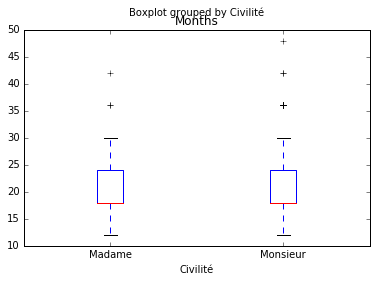

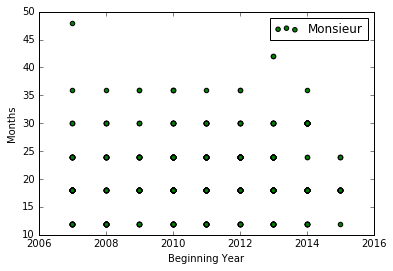

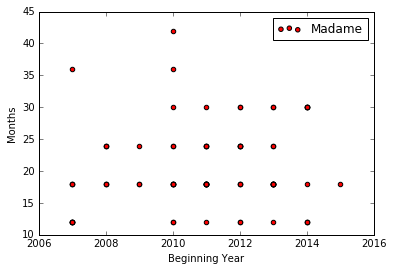

In [21]:
graduated_grouped = graduated_master.groupby(graduated_master.Civilité)
print(graduated_grouped['Months'].mean())
print(graduated_grouped['Months'].describe())


graduated_master.boxplot(column='Months', by='Civilité', grid=False)

splitted = [graduated_grouped.get_group(x) for x in graduated_grouped.groups]
for ind, part in enumerate(splitted):
    if ind==0: part.plot(kind='scatter', x='Beginning Year', y='Months', color='Green', label=part['Civilité'][0])
    else: part.plot(kind='scatter', x='Beginning Year', y='Months', color='Red', label=part['Civilité'][0])
stats.ttest_ind(a=splitted[0]['Months'], b=splitted[1]['Months'], equal_var=False)